In [2]:
import reverb

In [34]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import tf_agents
import gym
import gym_maze

In [4]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [5]:
import pygame
pygame.init()
pygame.display.list_modes()

[(1024, 768)]

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from IPython.display import clear_output
import time

## Maze Environment

The maze environment implementation we will use is an open source custom OpenAI Gym environment called [Gym-Maze](https://github.com/MattChanTK/gym-maze).

> [Gym-Maze is a] simple 2D maze environment where an agent (blue dot) finds its way from the top left corner (blue square) to the goal at the bottom right corner (red square). The objective is to find the shortest path from the start to the goal. The agent may only choose to go up, down, right, or left ("N", "S", "E", "W"). If the way is blocked, it will remain at the same the location. The observation space is the (x, y) coordinate of the agent. The top left cell is (0, 0). A reward of 1 is given when the agent reaches the goal. For every step in the maze, the agent recieves a reward of -0.1/(number of cells).

In [7]:
def make_maze_env():
    random.seed(0)
    env = gym.make("maze-random-10x10-plus-v0")
    env.reset()
    return env

In [8]:
env = make_maze_env()

In [9]:
img = env.render()

In [10]:
def dark_mode_maze(img, brighten_darks=30, brighten_mids=50, light_thresh=240, dark_thresh=50):
    img_rgb_sum = np.sum(img, axis=-1)
    light_region = (img_rgb_sum > light_thresh*3)
    light_region = np.repeat(light_region[:, :, np.newaxis], 3, axis=-1)
    
    dark_region = (img_rgb_sum < dark_thresh*3)
    dark_region = np.repeat(dark_region[:, :, np.newaxis], 3, axis=-1)
    
    other_regions = ~(light_region | dark_region)
    
    img[light_region] = 255 - img[light_region] + brighten_darks
    img[dark_region] = 255 - img[dark_region]
    img[other_regions] = img[other_regions] + brighten_mids
    
    return np.clip(img, 0, 255)

def render(env, dark_mode=True, figsize=None, title=None):
    img = env.render()
    sizes = np.shape(img)

    fig = plt.figure(figsize=figsize)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    ax.imshow(dark_mode_maze(img) if dark_mode else img)
    ax.set_title(title)
    
    plt.show()

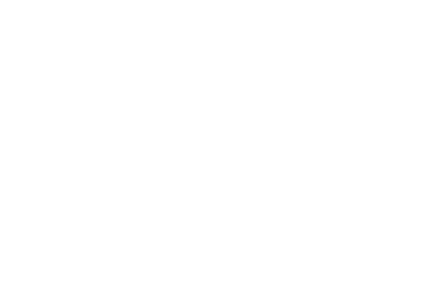

In [13]:
try:
    env.reset()
    title = f'Action: None'
    while True:
        # render
        render(env, title=title)
        clear_output(wait=True)
        time.sleep(0.05)
        
        # act
        random_action = env.action_space.sample()
        title = f'Action: {env.ACTION[random_action]}'
        env.step(random_action)
        
except KeyboardInterrupt:
    pass

## Tracking and Setting States

In order to construct a search tree over the environment we need to be able to track and set the object-level states. Each node in a search tree will hold a state that we have explored, but we do not want to constantly copy the entire environment object as most of this will be irrelevant information. In order to perform a node expansion we will set the environment state to the state of the node, perform an action using `env.step`, and create a new child node from the resultant state of the environment.

The Gym-Maze environment tracks the state of the robot in the maze with the `env.state` and `env.maze_view._MazeView2D__robot` variables. But we also need to track the `env.steps_beyond_done` and `env.done` variables in order to prevent issues when we use `env.step`. When setting a state we follow the same procedure as `env.reset`, except with our target variables. This procedure can be seen [here in the Gym-Maze source code](https://github.com/MattChanTK/gym-maze/blob/83176811b49b5538a6213520612f44fb1bc49114/gym_maze/envs/maze_env.py#L92).

### Creating getters/setters

Reseting the environment and taking a random direction

In [14]:
env = make_maze_env()

In [15]:
move_right_action = 2
env.step(move_right_action)

(array([1, 0]), -0.001, False, {})

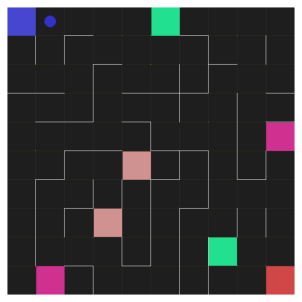

In [16]:
render(env)

Keep note of this state, as it is what we will aim to restore

Defining the state getters and setters

In [154]:
def get_state(env):
    return (np.array(env.state.copy()), env.steps_beyond_done, env.done)


def set_state(env, state):    
    robot_state, steps_beyond_done, done = state 
    
    env.maze_view._MazeView2D__draw_robot(transparency=0)
    env.maze_view._MazeView2D__robot = robot_state
    env.maze_view._MazeView2D__draw_robot(transparency=255)
    
    env.state = robot_state
    env.steps_beyond_done = steps_beyond_done
    env.done = done

Storing the current state to show the getter work

In [155]:
state = get_state(env)
state

(array([1, 0]), None, False)

Taking another step to the right.

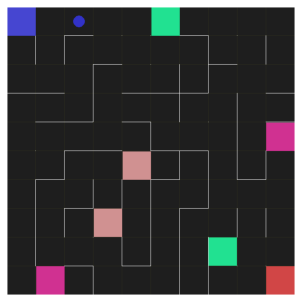

In [156]:
env.step(move_right_action)
render(env)

Seeing that the `set_state` function correctly restores the original state before the second step.

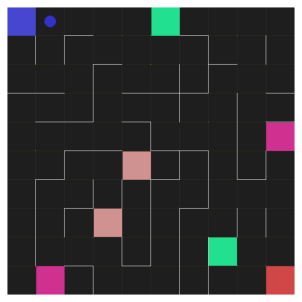

In [157]:
set_state(env, state)
render(env)

Move down from the restored state.

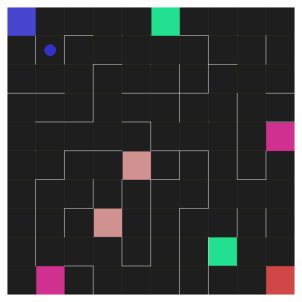

In [158]:
move_down_action = 1
env.step(move_down_action)
render(env)

## Search Tree Representation

In [17]:
from abc import ABC, abstractmethod
from typing import Callable, Any, List, Tuple, Dict
from collections import defaultdict


class ObjectState(ABC):
    
    @staticmethod
    @abstractmethod
    def extract_state(env: gym.Env) -> 'ObjectState':
        pass
    
    @abstractmethod
    def set_environment_to_state(self, env: gym.Env):
        pass
    
    @abstractmethod
    def get_state_vector(self) -> np.array:
        pass


class SearchTreeNode:
    __slots__ = ['state', 'action', 'reward', 'children']
    
    def __init__(self, state: ObjectState, action: int, reward: float):
        self.state = state
        self.action = action
        self.reward = reward
        self.children: Dict[int, List['SearchTreeNode']] = defaultdict(list)
        
    def get_children(self) -> Dict[int, List['SearchTreeNode']]:
        return self.children
        
    def expand_node(self, env: gym.Env, action: int) -> 'SearchTreeNode':
        self.state.set_environment_to_state(env) 
            
        obs, reward, *_ = env.step(action)
        next_state: ObjectState = self.state.extract_state(env)
        
        child_node = SearchTreeNode(next_state, action, reward)
        self.children[action].append(child_node)
        return child_node
    
    def get_trajectory(self) -> Tuple[int, float, ObjectState]:
        return (self.action, self.reward, self.state)

    def __repr__(self) -> str:
        return f'action={self.action}, reward={self.reward}, state={self.state}, children={self.children}'


class SearchTree:
    
    def __init__(self, env: gym.Env, extract_state: Callable):
        self.env = env
        
        self.root_node: SearchTreeNode = SearchTreeNode(extract_state(env), None, 0)
        self.node_list: List[SearchTreeNode] = [self.root_node]
    
    def expand(self, node_idx: int, action: int):
        node = self.node_list[node_idx]
        child_node = node.expand_node(self.env, action)
        self.node_list.append(child_node)
        
    def get_nodes(self) -> List[SearchTreeNode]:
        return self.node_list
    
    def get_root(self) -> SearchTreeNode:
        return self.root_node
    
    def __repr__(self) -> str:
        return str(self.root_node)

In [18]:
class MazeState(ObjectState):
    __slots__ = ['state_vec', 'gym_state']
    
    @staticmethod
    def extract_state(env: gym_maze.envs.maze_env.MazeEnv) -> 'MazeState':    
        state_vec = np.array(env.maze_view._MazeView2D__robot.copy(), dtype=np.int32)
        gym_state = (state_vec, env.steps_beyond_done, env.done)
        return MazeState(state_vec, gym_state)
    
    def __init__(self, state_vec: np.array, gym_state: tuple):
        self.state_vec = state_vec
        self.gym_state = gym_state
    
    def set_environment_to_state(self, env: gym_maze.envs.maze_env.MazeEnv):
        robot_pos, steps_beyond_done, done = self.gym_state 

        env.maze_view._MazeView2D__draw_robot(transparency=0)
        env.maze_view._MazeView2D__robot = robot_pos.copy()
        env.maze_view._MazeView2D__draw_robot(transparency=255)

        env.state = robot_pos.copy()
        env.steps_beyond_done = steps_beyond_done
        env.done = done
        
    def get_state_vector(self) -> np.array:
        return self.state_vec
    
    def __repr__(self) -> str:
        return str(tuple(map(int, self.state_vec)))

In [25]:
maze_state = MazeState.extract_state(env)
maze_state.get_state_vector()

array([0, 0], dtype=int32)

In [26]:
env = make_maze_env()

search_tree = SearchTree(env, MazeState.extract_state)
search_tree

action=None, reward=0, state=(0, 0), children=defaultdict(<class 'list'>, {})

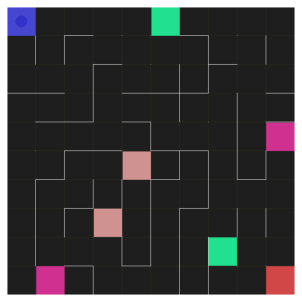

In [27]:
render(env)

In [23]:
import random
random.seed(0)

N = 50
for i in range(N):
    node = random.choice(list(range(len(search_tree.get_nodes()))))
    action = random.randint(0, env.action_space.n - 1)
    if N <= 10:
        print(f'Expanding {search_tree.get_nodes()[node].state} with action {env.ACTION[action]}')
    search_tree.expand(node, action)

In [24]:
import networkx as nx

def construct_tree(tree: nx.DiGraph, node: SearchTreeNode):
    tree.add_node(hash(node), state=str(node.state))
    for action, children in node.get_children().items():
        for child in children:
            construct_tree(tree, child)
            tree.add_edge(hash(node), hash(child), action=env.ACTION[action])


nx_tree = nx.DiGraph()
construct_tree(nx_tree, search_tree.get_root())

In [25]:
from mlrl.utils import hierarchy_pos_large_tree

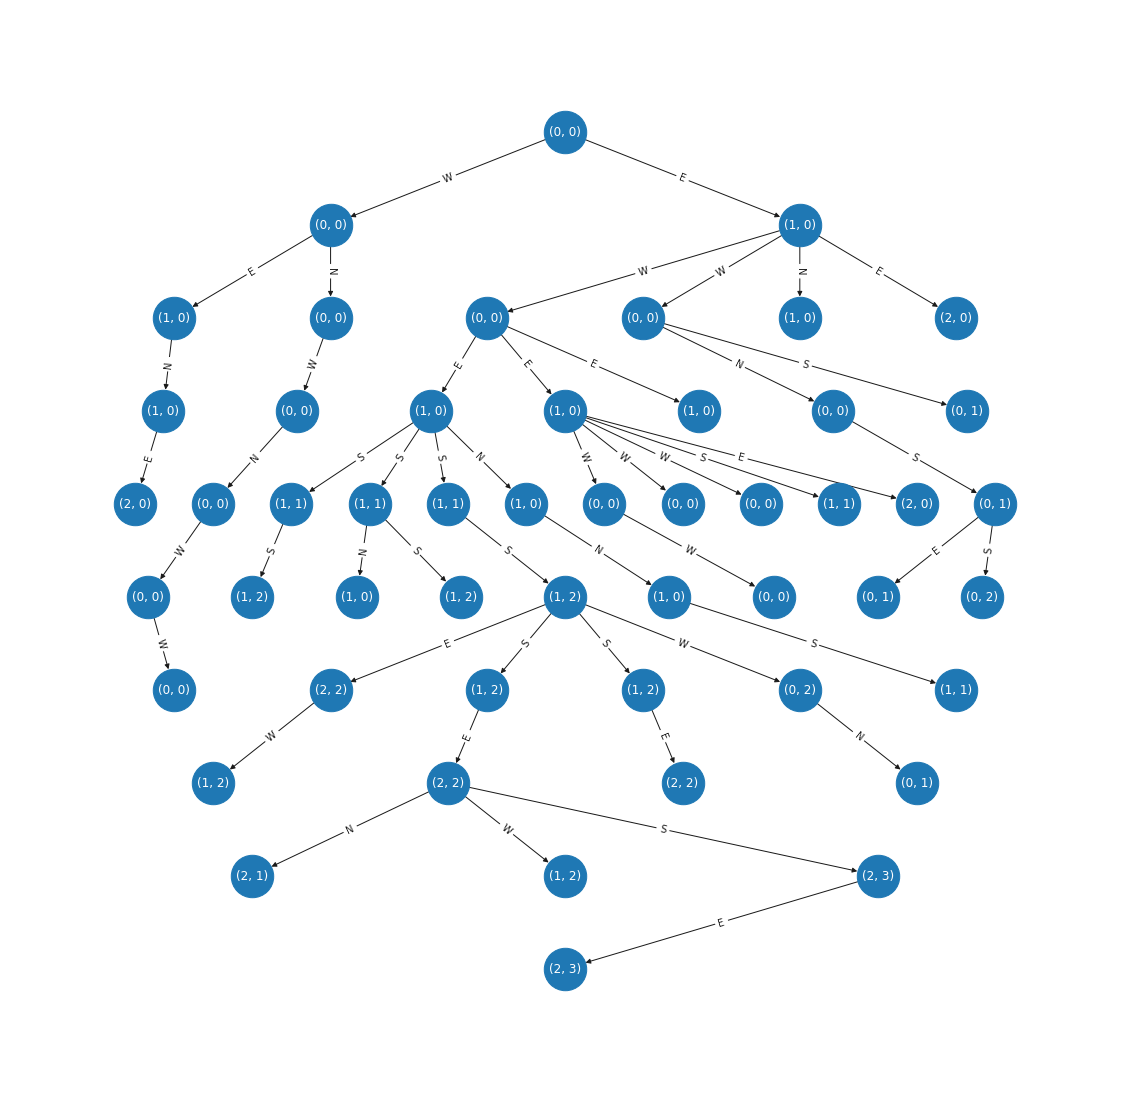

In [26]:
from networkx.drawing.nx_pydot import graphviz_layout

pos = hierarchy_pos_large_tree(nx_tree, hash(search_tree.get_root()), width=250, height=250)
edge_labels = {
    (n1, n2): data['action'] 
    for n1, n2, data in nx_tree.edges(data=True)
}
node_labels = {
    node: nx_tree.nodes.get(node)['state'] for node in nx_tree.nodes()
}

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot()

nx.draw(nx_tree, pos, node_size=1800, ax=ax)

nx.draw_networkx_edge_labels(nx_tree, pos, edge_labels=edge_labels, ax=ax)
nx.draw_networkx_labels(nx_tree, pos, labels=node_labels, ax=ax, font_color='white')
plt.axis('off')
axis = plt.gca()
zoom = 10
axis.set_xlim([axis.get_xlim()[0] - zoom, axis.get_xlim()[1] + zoom])
axis.set_ylim([axis.get_ylim()[0] - zoom, axis.get_ylim()[1] + zoom])
# plt.tight_layout()
plt.show()

## Training Q-agent

In [28]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

num_actions = env.action_space.n

In [29]:
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [30]:
def build_model(obs_shape, num_actions):
    model = tf.keras.Sequential()    
    model.add(tf.keras.layers.Dense(24, activation='relu', input_shape=obs_shape))
    model.add(tf.keras.layers.Dense(24, activation='relu'))
    model.add(tf.keras.layers.Dense(num_actions, activation='linear'))
    return model

In [43]:
tf_agents.environments.BatchedPyEnvironment?

Init signature:
tf_agents.environments.BatchedPyEnvironment(
    envs: Sequence[tf_agents.environments.py_environment.PyEnvironment],
    multithreading: bool = True,
)
Docstring:     
Batch together multiple py environments and act as a single batch.

The environments should only access shared python variables using
shared mutex locks (from the threading module).
Init docstring:
Batch together multiple (non-batched) py environments.

The environments can be different but must use the same action and
observation specs.

Args:
  envs: List python environments (must be non-batched).
  multithreading: Python bool describing whether interactions with the
    given environments should happen in their own threadpool.  If `False`,
    then all interaction is performed serially in the current thread.

    This may be combined with wrapper `TFPyEnvironment(..., isolation=True)`
    to ensure that multiple environments are all run in the same thread.

Raises:
  ValueError: If envs is not a list 

In [31]:
tf_env = tf_py_environment.TFPyEnvironment(tf_agents.environments.gym_wrapper.GymWrapper(env))

In [35]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(tf_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
    return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [36]:
print("TimeStep Specs:", tf_env.time_step_spec())
print("Action Specs:", tf_env.action_spec())

TimeStep Specs: TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(2,), dtype=tf.int64, name='observation', minimum=array(0), maximum=array(9)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})
Action Specs: BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(3))


In [37]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [38]:
random_policy = random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(),
                                                tf_env.action_spec())

In [39]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [55]:
compute_avg_return(tf_env, random_policy, num_eval_episodes)

0.38000032

In [ ]:
compute_avg_return(tf_env, agent.policy, 1)

In [56]:
import reverb

table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

In [57]:
# dataset = replay_buffer.as_dataset(
#     num_parallel_calls=3,
#     sample_batch_size=batch_size,
#     num_steps=2).prefetch(3)

# dataset

In [59]:
collect_driver

NameError: name 'collect_driver' is not defined

In [58]:
env.reset()

array([0., 0.])

In [53]:
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(tf_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    tf_env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_driver.run(time_step)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(tf_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

KeyboardInterrupt: 

## Search-Amplified Object-level Q-Value Estimation

In [16]:
import tensorflow as tf

In [173]:
class SimpleSearchBasedQEstimator:
    """
        Assumes a deterministic environment and only uses child nodes to compute Q-values
    """
    
    def __init__(self, goal_state: np.array, n_actions: int = 4, discount: float = 0.99):
        self.n_actions = n_actions
        self.discount = discount
        self.goal_state = goal_state
    
    def compute_q(self, search_tree_node: SearchTreeNode, action: int) -> float:
        children = search_tree_node.get_children()
        if action in children:
            child_node = children[action][0]
            action_taken, reward, next_state = child_node.get_trajectory()
            return reward + self.discount * self.compute_value(child_node)
        np.abs(env.state - env.maze_view.goal).sum()
        return 0
        
    def compute_value(self, search_tree_node: SearchTreeNode) -> float:
        return max(self.compute_q(search_tree_node, action) for action in range(self.n_actions))

In [174]:
q_est = SimpleSearchBasedQEstimator()

In [175]:
q_est.compute_value(search_tree.get_root())

0

In [180]:
env.state

array([1, 0], dtype=int32)

17